# Cytation 5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from pylabrobot.plate_reading import PlateReader, Cytation5Backend

In [3]:
pr = PlateReader(name="PR", size_x=0,size_y=0,size_z=0, backend=Cytation5Backend())
await pr.setup()

In [4]:
await pr.backend.get_firmware_version()

'1320200  Version 2.07'

In [5]:
await pr.backend.get_current_temperature()

22.9

In [6]:
await pr.open()

In [7]:
await pr.close()

## Plate reading

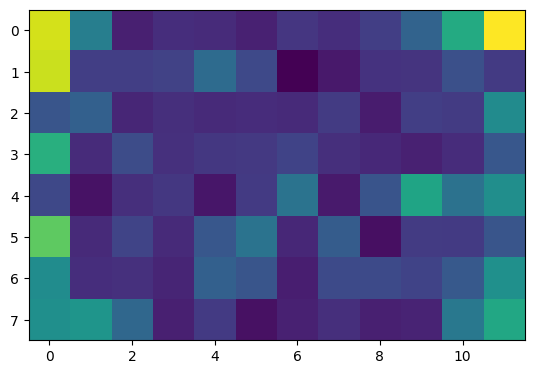

In [8]:
data = await pr.read_absorbance(wavelength=434)
plt.imshow(data)

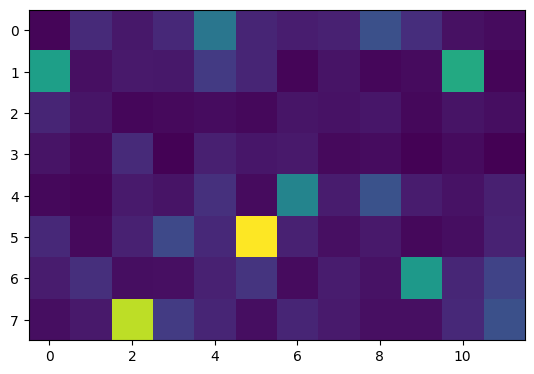

In [9]:
data = await pr.read_fluorescence(excitation_wavelength=485, emission_wavelength=528, focal_height=7.5)
plt.imshow(data)

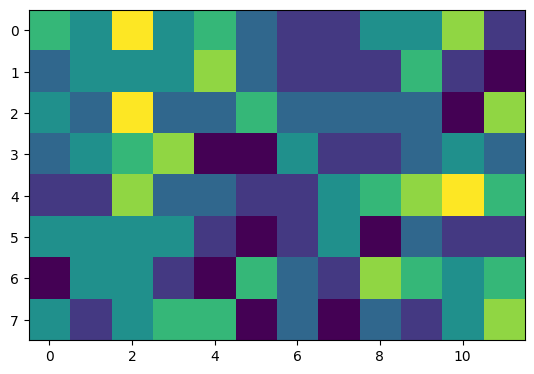

In [31]:
data = await pr.read_luminescence(focal_height=4.5)
plt.imshow(data)

## Shaking

In [10]:
await pr.backend.shake(shake_type=Cytation5Backend.ShakeType.LINEAR)

In [11]:
await pr.backend.stop_shaking()